<a href="https://colab.research.google.com/github/DamodaraBarbosa/eleicoes_ceara_2022/blob/main/municipios_ceara_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans

# 1. Carregando dados

In [2]:
# Dados referentes aos cargos disputados no estado do Ceará:

votacao_ce = pd.read_csv(
    '/content/drive/MyDrive/Datasets/votacao_secao_2022_CE_tratado.csv',
    encoding= 'latin-1', sep= ','
)

# Visualização das primeiras observações do dataframe:

votacao_ce.head()

,nm_municipio,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos
0,FORTALEZA,94,6,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4
1,RUSSAS,9,266,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,13
2,PARAIPABA,109,119,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,3
3,ITAPIPOCA,17,25,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,2
4,SABOEIRO,43,228,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4


In [3]:
# Dados referetes ao cargo de presidente da república:

presidente = pd.read_csv(
    '/content/drive/MyDrive/eleições_ceará_2022/votacao_secao_2022_BR.csv',
    encoding= 'latin-1', sep= ';'
)

presidente_ce = presidente.query('SG_UF == "CE"')[['NM_MUNICIPIO', 'DS_CARGO', 'NR_TURNO', 'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS']]

# Visualização das primeiras observações do dataframe:

presidente_ce.head()

,NM_MUNICIPIO,DS_CARGO,NR_TURNO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
7,JUCÁS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,212
57,GRANJA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,144
84,BATURITÉ,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,213
90,NOVA RUSSAS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,148
136,FORTALEZA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,169


In [4]:
# Dados referetes aos indicadores do IBGE dos municípios cearenses:

ibge_ce = pd.read_csv(
    '/content/drive/MyDrive/Datasets/resumo_dados_ibge_ce.csv',
    encoding= 'latin-1', sep= ','
)


# Visualização das primeiras observações do dataframe:

ibge_ce.head()

,nome,area_territorio,populacao,idhm,pib_per_capita,area_urbanizada,porcentagem_urbana,densidade_populacional
0,ABAIARA,180.833,11965,0.628,9158.04,3.19,1.76,66.17
1,ACARAPE,130.002,15140,0.606,10317.47,2.28,1.75,116.46
2,ACARAÚ,842.471,63556,0.601,13261.89,16.33,1.94,75.44
3,ACOPIARA,2254.279,54687,0.595,9432.25,5.46,0.24,24.26
4,AIUABA,2438.563,17584,0.569,8642.90,2.07,0.08,7.21


# 2. Tratamento dos dados referentes a eleição presidencial

Os nomes das colunas no dataframe `presidente_ce` estão em caixa. Por questões estéticas e para facilitar o acesso das informações.

In [5]:
presidente_ce = presidente_ce.rename({
    'NM_MUNICIPIO': 'nm_municipio', 'DS_CARGO': 'ds_cargo',
    'NR_VOTAVEL': 'nr_votavel', 'NM_VOTAVEL': 'nm_votavel',
    'QT_VOTOS': 'qt_votos', 'NR_TURNO': 'nr_turno'
}, axis= 1)

presidente_ce.head()

,nm_municipio,ds_cargo,nr_turno,nr_votavel,nm_votavel,qt_votos
7,JUCÁS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,212
57,GRANJA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,144
84,BATURITÉ,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,213
90,NOVA RUSSAS,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,148
136,FORTALEZA,PRESIDENTE,1,13,LUIZ INÁCIO LULA DA SILVA,169


# 3. Ajustando os dados para o modelo de *clustering*

## 3.1 Votos válidos no 1º e 2º turno

In [6]:
votacao_ce = votacao_ce.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]')
votos_validos_primeiro = votacao_ce.query('ds_cargo == "GOVERNADOR"')['qt_votos'].sum()
votos_validos_primeiro

5198892

In [7]:
presidente_ce = presidente_ce.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]')
votos_validos_pres_primeiro = presidente_ce.query('nr_turno == 1')['qt_votos'].sum()
votos_validos_pres_segundo = presidente_ce.query('nr_turno == 2')['qt_votos'].sum()

In [8]:
print(f'Votos válidos no 1º turno: {votos_validos_pres_primeiro}')
print(f'Votos válidos no 2º turno: {votos_validos_pres_segundo}')

Votos válidos no 1º turno: 5429264
Votos válidos no 2º turno: 5442368


## 3.2 Votos nos principais candidatos para diferentes cargos

In [9]:
def votos_validos_por_cidade(dataframe: pd.DataFrame, turno: int= 1, cargo: str= 'PRESIDENTE'):
  if cargo != 'PRESIDENTE':
    votos_validos_por_cidade = dataframe.query('ds_cargo == @cargo').groupby('nm_municipio')['qt_votos'].sum()
  else:
    votos_validos_por_cidade = dataframe.query('nr_turno == @turno').groupby('nm_municipio')['qt_votos'].sum()

  dict_votos_validos_por_cidade = dict(votos_validos_por_cidade)

  return dict_votos_validos_por_cidade

def porcentagem_de_votos(dataframe: pd.DataFrame, votos: dict, n_candidatos: int= 3, turno: int= 1, cargo: str= 'PRESIDENTE'):
  if cargo != 'PRESIDENTE':
    dataframe = dataframe.query('ds_cargo == @cargo').groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum().to_frame()
  else:
    dataframe = dataframe.query('nr_turno == @turno').groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum().to_frame()

  dataframe = dataframe.sort_values(['nm_municipio', 'qt_votos'], ascending= [True, False])
  dataframe = dataframe.groupby('nm_municipio').head(n_candidatos)
  dataframe = dataframe.reset_index()

  for row in dataframe.iterrows():
    index= row[0]
    row = row[1]
    porcentagem = row['qt_votos']/votos[row['nm_municipio']]
    dataframe.at[index, 'qt_votos'] = porcentagem


  return dataframe

def formatar_dataframe(dataframe: pd.DataFrame, index: str, columns: str, values: str, cargo: str, turno: int= None):
  array_candidatos = dataframe['nm_votavel'].unique()
  list_candidatos_ordenados = sorted(list(array_candidatos)) # os candidatos são ordenados em ordem alfabética.
  new_dataframe = dataframe.pivot(index= index, columns= columns, values= values)

  if turno != None:
    new_dataframe.columns = [(cargo + '_' + f'{turno}_turno_' + candidato.split()[0]).lower() for candidato in list_candidatos_ordenados]
  else:
    new_dataframe.columns = [(cargo + '_'  + candidato.split()[0]).lower() for candidato in list_candidatos_ordenados]

  new_dataframe = new_dataframe.reset_index()

  return new_dataframe





In [10]:
votos_validos_governador = votos_validos_por_cidade(votacao_ce, cargo= 'GOVERNADOR')
votos_validos_senador = votos_validos_por_cidade(votacao_ce, cargo= 'SENADOR')
votos_validos_presidente = votos_validos_por_cidade(presidente_ce)

In [11]:
porcentagem_governador_por_cidade = porcentagem_de_votos(votacao_ce, votos= votos_validos_governador, cargo= 'GOVERNADOR')
porcentagem_governador_por_cidade = formatar_dataframe(
    porcentagem_governador_por_cidade, index= 'nm_municipio', columns= 'nm_votavel',
    values= 'qt_votos', cargo= 'GOVERNADOR'
)
porcentagem_governador_por_cidade.head()

,nm_municipio,governador_elmano,governador_roberto,governador_wagner
0,ABAIARA,0.793548,0.066983,0.137381
1,ACARAPE,0.502539,0.076483,0.420547
2,ACARAÚ,0.614294,0.046130,0.339067
3,ACOPIARA,0.637880,0.167552,0.193612
4,AIUABA,0.503980,0.362438,0.131343


In [12]:
porcentagem_senador_por_cidade = porcentagem_de_votos(votacao_ce, votos= votos_validos_senador, cargo= 'SENADOR')
porcentagem_senador_por_cidade = formatar_dataframe(
    porcentagem_senador_por_cidade, index= 'nm_municipio', columns= 'nm_votavel',
    values= 'qt_votos', cargo= 'SENADOR'
)
porcentagem_senador_por_cidade.isna().sum()

nm_municipio      0
senador_camilo    0
senador_erika     0
senador_kamila    0
dtype: int64

In [13]:
porcentagem_votos_pres_prim_turno = porcentagem_de_votos(dataframe= presidente_ce, votos= votos_validos_presidente)
porcentagem_votos_pres_prim_turno = formatar_dataframe(
    porcentagem_votos_pres_prim_turno, index= 'nm_municipio', columns= 'nm_votavel',
    values= 'qt_votos', cargo= 'PRESIDENTE', turno= 1
)
porcentagem_votos_pres_prim_turno.head()

,nm_municipio,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz
0,ABAIARA,0.032145,0.104339,0.855437
1,ACARAPE,0.035048,0.324036,0.621734
2,ACARAÚ,0.059211,0.234469,0.694551
3,ACOPIARA,0.060203,0.132702,0.794262
4,AIUABA,0.051150,0.098706,0.839722


In [14]:
porcentagem_votos_pres_seg_turno = porcentagem_de_votos(dataframe= presidente_ce, votos= votos_validos_presidente, n_candidatos= 2, turno= 2)
porcentagem_votos_pres_seg_turno = formatar_dataframe(
    porcentagem_votos_pres_seg_turno, index= 'nm_municipio', columns= 'nm_votavel',
    values= 'qt_votos', cargo= 'PRESIDENTE', turno= 2
)
porcentagem_votos_pres_seg_turno.head()

,nm_municipio,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.127349,0.882663
1,ACARAPE,0.365616,0.649316
2,ACARAÚ,0.271472,0.738741
3,ACOPIARA,0.167977,0.844722
4,AIUABA,0.115117,0.886200


# 4. *Merge* dos *dataframes*

In [15]:
# dados_eleicao = pd.merge(
#     left= ibge_ce, right= votos_governador_por_cidade,
#     how= 'inner', left_on= 'nome', right_on= 'index'

# )
# dados_eleicao = dados_eleicao.drop('index', axis= 1)

In [16]:
dados_eleicao = porcentagem_governador_por_cidade

In [17]:
dados_eleicao = pd.merge(
    left= dados_eleicao, right= porcentagem_senador_por_cidade,
    how= 'inner', left_on= 'nm_municipio', right_on= 'nm_municipio'

)


In [18]:
dados_eleicao = pd.merge(
    left= dados_eleicao, right= porcentagem_votos_pres_prim_turno,
    how= 'inner', left_on= 'nm_municipio', right_on= 'nm_municipio'

)


In [19]:
dados_eleicao = pd.merge(
    left= dados_eleicao, right= porcentagem_votos_pres_seg_turno,
    how= 'inner', left_on= 'nm_municipio', right_on= 'nm_municipio'

)


In [20]:
dados_eleicao

,nm_municipio,governador_elmano,governador_roberto,governador_wagner,senador_camilo,senador_erika,senador_kamila,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.793548,0.066983,0.137381,0.894918,0.003644,0.101033,0.032145,0.104339,0.855437,0.127349,0.882663
1,ACARAPE,0.502539,0.076483,0.420547,0.634346,0.021611,0.344043,0.035048,0.324036,0.621734,0.365616,0.649316
2,ACARAÚ,0.614294,0.046130,0.339067,0.719278,0.006223,0.273957,0.059211,0.234469,0.694551,0.271472,0.738741
3,ACOPIARA,0.637880,0.167552,0.193612,0.732746,0.134316,0.132669,0.060203,0.132702,0.794262,0.167977,0.844722
4,AIUABA,0.503980,0.362438,0.131343,0.920011,0.013200,0.065998,0.051150,0.098706,0.839722,0.115117,0.886200
...,...,...,...,...,...,...,...,...,...,...,...,...
179,URUBURETAMA,0.688114,0.048496,0.262729,0.780895,0.019587,0.199518,0.047903,0.227451,0.712091,0.261678,0.740216
180,URUOCA,0.731313,0.032775,0.235911,0.810733,0.006599,0.182543,0.041289,0.179264,0.769240,0.210001,0.788049
181,VARJOTA,0.454804,0.315992,0.228282,0.788779,0.023317,0.187813,0.180517,0.209458,0.595473,0.273323,0.713581
182,VIÇOSA DO CEARÁ,0.682759,0.094712,0.221906,0.796061,0.051772,0.152166,0.058508,0.184596,0.740284,0.232871,0.786518


# 5. Modelagem da clusterização dos municípios cearenses

## 5.1 Pré-processamento dos dados

In [21]:
# colunas_pre_processamento = dados_eleicao.drop('nm_municipio', axis= 1).columns

In [22]:
# from sklearn.preprocessing import StandardScaler

In [23]:
# scaler = MinMaxScaler()

In [24]:
# dados_eleicao[colunas_pre_processamento] = scaler.fit_transform(dados_eleicao[colunas_pre_processamento])

## 5.2 Redução de dimensionalidade com PCA

In [25]:
pca = PCA(n_components= 2)

In [26]:
dados_pca = pca.fit_transform(dados_eleicao.drop('nm_municipio', axis= 1))

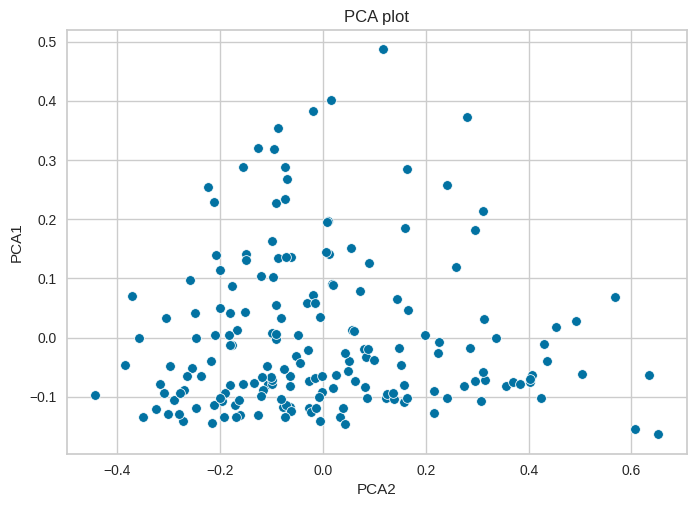

In [27]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1])
ax.set_title('PCA plot')
ax.set_ylabel('PCA1')
ax.set_xlabel('PCA2')
plt.show()

In [28]:
pca.explained_variance_ratio_

array([0.67050267, 0.23141421])

## 5.3 Definição do número ideal de *clusters*

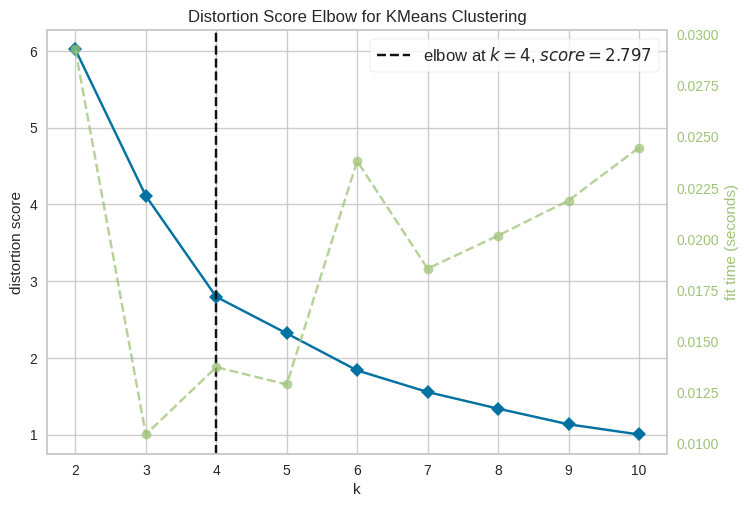

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
Elbow_M = KElbowVisualizer(KMeans(init= 'k-means++', max_iter= 300, n_init= 10, random_state= 42), k=10)
Elbow_M.fit(dados_pca)
Elbow_M.show()

In [30]:
kmeans = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300, n_init= 10, random_state= 0)

clusters = kmeans.fit_predict(dados_pca)

In [31]:
centroides = kmeans.cluster_centers_
centroides

array([[-0.23037927, -0.05268866],
       [-0.02928757,  0.23072239],
       [ 0.3682977 , -0.03458444],
       [ 0.01079136, -0.04810731]])

In [32]:
classificacao = kmeans.labels_
classificacao

array([0, 2, 3, 1, 1, 1, 0, 0, 3, 0, 1, 2, 2, 3, 3, 0, 3, 1, 0, 3, 1, 1,
       3, 2, 0, 1, 3, 3, 3, 0, 1, 1, 0, 3, 3, 3, 3, 3, 0, 2, 2, 0, 0, 2,
       1, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 3, 0, 0, 0, 2,
       3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 2, 3, 2, 3,
       3, 2, 0, 0, 3, 3, 2, 0, 1, 2, 3, 3, 1, 3, 0, 2, 2, 2, 0, 3, 3, 3,
       0, 1, 0, 0, 3, 1, 3, 3, 2, 0, 3, 0, 3, 0, 3, 1, 2, 2, 3, 0, 2, 3,
       2, 2, 3, 3, 0, 1, 3, 0, 3, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 3, 3, 1,
       3, 0, 1, 1, 0, 0, 3, 3, 2, 0, 3, 2, 1, 3, 0, 3, 0, 1, 3, 2, 3, 3,
       2, 1, 1, 3, 3, 1, 3, 0], dtype=int32)

In [33]:
dados_eleicao['clusters'] = classificacao

In [34]:
dados_eleicao.query('clusters == 1')

,nm_municipio,governador_elmano,governador_roberto,governador_wagner,senador_camilo,senador_erika,senador_kamila,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz,presidente_2_turno_jair,presidente_2_turno_luiz,clusters
3,ACOPIARA,0.637880,0.167552,0.193612,0.732746,0.134316,0.132669,0.060203,0.132702,0.794262,0.167977,0.844722,1
4,AIUABA,0.503980,0.362438,0.131343,0.920011,0.013200,0.065998,0.051150,0.098706,0.839722,0.115117,0.886200,1
5,ALCÂNTARAS,0.580563,0.228190,0.189827,0.836153,0.067368,0.096174,0.100381,0.109222,0.782780,0.137378,0.866703,1
10,APUIARÉS,0.574007,0.211285,0.213982,0.707473,0.130549,0.161429,0.055494,0.173283,0.759124,0.203280,0.782822,1
17,ARNEIROZ,0.527266,0.324245,0.148097,0.826150,0.074036,0.099608,0.059764,0.151694,0.779026,0.169014,0.795775,1
20,BAIXIO,0.560117,0.307748,0.131163,0.680846,0.242432,0.076461,0.059967,0.112204,0.822675,0.127196,0.860389,1
21,BANABUIÚ,0.534038,0.292008,0.173192,0.856774,0.011312,0.131825,0.042993,0.147251,0.802480,0.160480,0.796362,1
25,BARROQUINHA,0.502912,0.350740,0.144630,0.586388,0.315880,0.097731,0.075524,0.151782,0.763230,0.176222,0.799430,1
30,BREJO SANTO,0.524521,0.260822,0.213760,0.838714,0.008608,0.152559,0.042324,0.156527,0.792473,0.183473,0.829083,1
31,CAMOCIM,0.458740,0.251796,0.288537,0.572649,0.248319,0.178850,0.108587,0.228587,0.648814,0.276035,0.730877,1


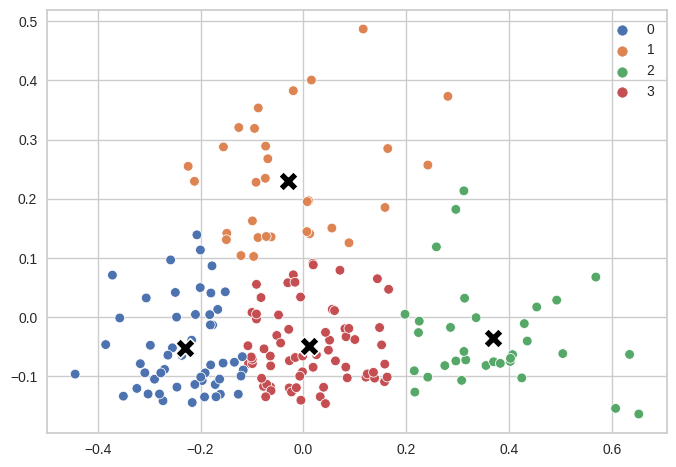

In [35]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1], hue= classificacao, palette= 'deep')
sns.scatterplot(x= centroides[:, 0], y= centroides[:, 1], marker= 'X', s= 200, color= 'black')
plt.show()

<Axes: >

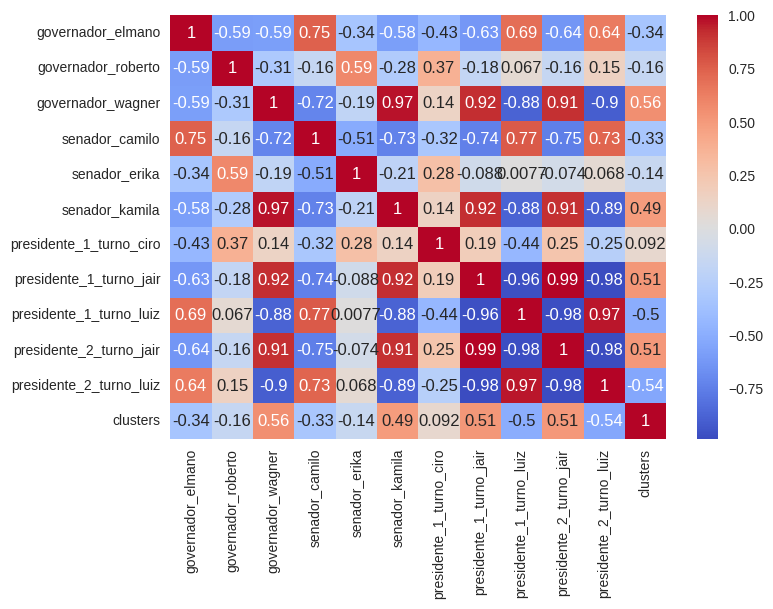

In [36]:
sns.heatmap(data= dados_eleicao.corr(numeric_only= True), annot= True, cmap= 'coolwarm')

<Axes: xlabel='governador_roberto', ylabel='governador_wagner'>

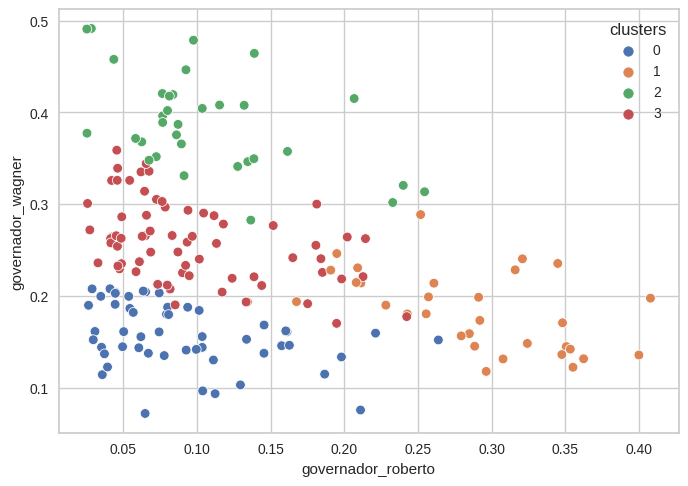

In [37]:
sns.scatterplot(data= dados_eleicao, x= 'governador_roberto', y= 'governador_wagner', hue= 'clusters', palette= 'deep')

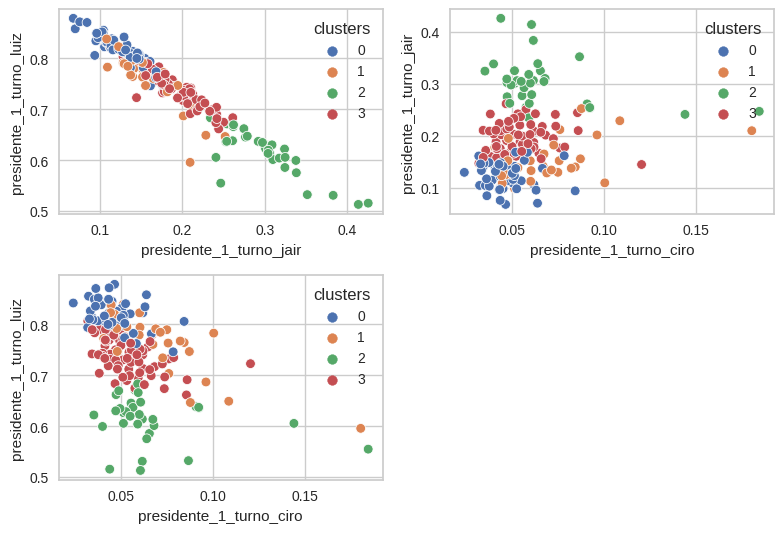

In [39]:
fig, ax = plt.subplots(2, 2)

ax1 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_jair', y= 'presidente_1_turno_luiz', hue= 'clusters', palette= 'deep', ax= ax[0, 0])
ax2 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_ciro', y= 'presidente_1_turno_jair', hue= 'clusters', palette= 'deep', ax= ax[0, 1])
ax3 = sns.scatterplot(data= dados_eleicao, x= 'presidente_1_turno_ciro', y= 'presidente_1_turno_luiz', hue= 'clusters', palette= 'deep', ax= ax[1, 0])
ax[1, 1].remove()
plt.tight_layout()
plt.show()

<Axes: xlabel='presidente_2_turno_jair', ylabel='presidente_2_turno_luiz'>

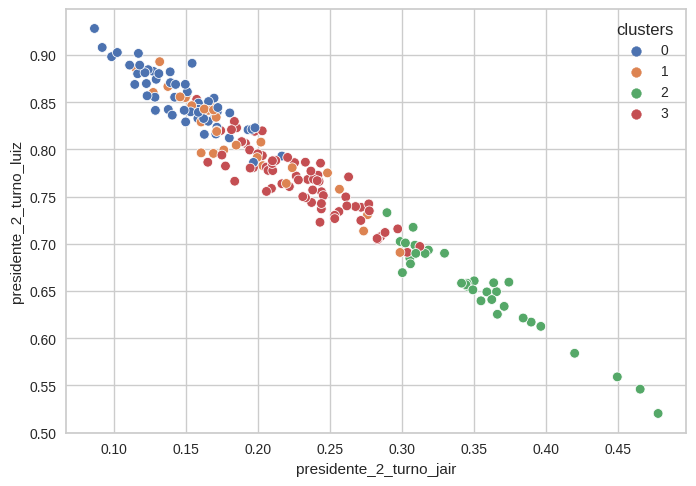

In [40]:
sns.scatterplot(data= dados_eleicao, x= 'presidente_2_turno_jair', y= 'presidente_2_turno_luiz', hue= 'clusters', palette= 'deep')